In [1]:
%pip install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 783.6/783.6 kB 32.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 53.2 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [ultralytics] [ultralytics]thop]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# === CONFIG: edit these for your setup ===
# MODEL_PATH = "runs/detect/nail-detector/weights/best.pt"  # path to your trained model

MODEL_PATH = "yolov8n.pt" 
# IMAGE_PATH = "data/test/finger_01.jpg"                    # path to a test image

IMAGE_PATH = "Fingernails/test/10125_jpg.rf.874dada59c3a6f742a5ce34591f204d2.jpg"

OUT_DIR = "outputs"                                       # where to save results
CONF_THRES = 0.25                                         # detection confidence threshold

os.makedirs(OUT_DIR, exist_ok=True)

In [5]:
def detect_and_crop_nail(
    model,
    image_path,
    out_dir="outputs",
    conf_thres=0.25,
    display_inline=True,
):
    """
    Detects the nail in an image using a YOLO model, crops it, saves results,
    and optionally displays them inline.

    Returns:
        crop_path, vis_path, nail_crop, vis_img
        (crop_path/vis_path may be None if detection fails)
    """
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")

    # Run inference
    results = model(img, conf=conf_thres)[0]  # first (and only) image
    boxes = results.boxes

    if len(boxes) == 0:
        print("No nail detected. Try lowering conf_thres or checking your model.")
        return None, None, None, None

    # Pick the highest-confidence detection
    best_idx = boxes.conf.argmax()
    box = boxes[best_idx]

    # Extract xyxy bounding box
    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

    # Clamp to image bounds (safety)
    h, w = img.shape[:2]
    x1 = max(0, min(x1, w - 1))
    x2 = max(0, min(x2, w - 1))
    y1 = max(0, min(y1, h - 1))
    y2 = max(0, min(y2, h - 1))

    if x2 <= x1 or y2 <= y1:
        print("Invalid bounding box after clamping; no crop saved.")
        return None, None, None, None

    # Crop nail region
    nail_crop = img[y1:y2, x1:x2]

    # Prepare filenames
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    crop_path = os.path.join(out_dir, f"{base_name}_nail_crop.jpg")
    vis_path = os.path.join(out_dir, f"{base_name}_nail_vis.jpg")

    # Save crop
    cv2.imwrite(crop_path, nail_crop)

    # Draw bounding box for visualization
    vis_img = img.copy()
    cv2.rectangle(vis_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    conf = float(box.conf.cpu().numpy())
    label = f"nail {conf:.2f}"
    cv2.putText(
        vis_img,
        label,
        (x1, max(y1 - 5, 0)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 255, 0),
        2,
        cv2.LINE_AA,
    )

    cv2.imwrite(vis_path, vis_img)

    print(f"Nail crop saved to: {crop_path}")
    print(f"Visualization saved to: {vis_path}")

    # Show inline in the notebook (optional)
    if display_inline:
        # Convert BGR (OpenCV) to RGB (matplotlib)
        nail_crop_rgb = cv2.cvtColor(nail_crop, cv2.COLOR_BGR2RGB)
        vis_rgb = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.title("Nail crop")
        plt.imshow(nail_crop_rgb)
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Detection visualization")
        plt.imshow(vis_rgb)
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    return crop_path, vis_path, nail_crop, vis_img

In [6]:
model = YOLO(MODEL_PATH)
print("Model loaded.")

Model loaded.



0: 640x640 1 person, 54.1ms
Speed: 1.5ms preprocess, 54.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Nail crop saved to: outputs/10125_jpg.rf.874dada59c3a6f742a5ce34591f204d2_nail_crop.jpg
Visualization saved to: outputs/10125_jpg.rf.874dada59c3a6f742a5ce34591f204d2_nail_vis.jpg


/var/folders/88/v7x7s0vx4qb5cjpy4rwrz1yr0000gn/T/ipykernel_71748/17628040.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf = float(box.conf.cpu().numpy())


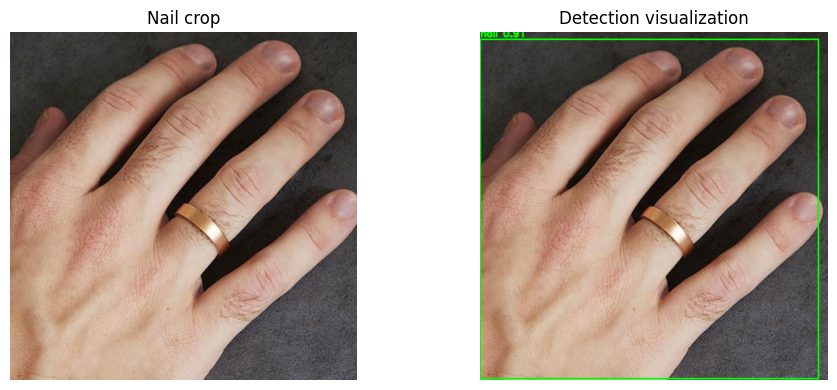

In [7]:
crop_path, vis_path, nail_crop, vis_img = detect_and_crop_nail(
    model=model,
    image_path=IMAGE_PATH,
    out_dir=OUT_DIR,
    conf_thres=CONF_THRES,
    display_inline=True,  # change to False if you don’t want plots
)